# Miniproject 1 - Classification
## Classification, weight sharing, auxiliary losses

The objective of this project is to test different architectures to compare two digits visible in a two-channel image. It aims at showing in particular the impact of weight sharing, and of the use of an auxiliary loss to help the training of the main objective.

### 0. Import library and define python3 as default

In [120]:
#!/usr/bin/env python3
""" File to solve the first miniproject which is classification """

import sys
import time
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import numpy as np

import torch
from torch.autograd import Variable
from torch import nn, optim
from torch.nn import functional as F
import dlc_practical_prologue as prologue


__author__ = 'Eugène Lemaitre, Natalie Bolón Brun, Louis Munier'
__version__ = '0.1'

### 1. Import and Process data

In [24]:
def import_data(N, normalize):
    """Function to import dataset from prologue"""
    train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N)

    # Normalize data
    if normalize:
        mu, std = train_input.mean(), train_input.std()
        train_input.sub_(mu).div_(std)
        test_input.sub_(mu).div_(std)

    return train_input, train_classes, train_target, test_input, test_classes, test_target

In [25]:
def to_one_hot(tensor):
    one_hot = torch.zeros((tensor.size(0), 10)).type(torch.FloatTensor)
    one_hot[list(range(0,tensor.size(0))), tensor] = 1
    return one_hot

In [26]:
def split_data(train_input, train_classes, test_input, test_classes):
    """Split data into two set, pictures up/down."""
    train_input_up = Variable(train_input[:, 0, :, :].reshape(train_input.size(0), 1, train_input.size(2), train_input.size(3)))
    train_input_down = Variable(train_input[:, 1, :, :].reshape(train_input.size(0), 1, train_input.size(2), train_input.size(3)))

    train_classes_up = Variable(to_one_hot(train_classes[:,0]))
    train_classes_down = Variable(to_one_hot(train_classes[:,1]))
    
    test_input_up = Variable(test_input[:, 0, :, :].reshape(test_input.size(0), 1, test_input.size(2), test_input.size(3)))
    test_input_down = Variable(test_input[:, 1, :, :].reshape(test_input.size(0), 1, test_input.size(2), test_input.size(3)))
    
    test_classes_up = Variable(to_one_hot(test_classes[:, 0]))
    test_classes_down = Variable(to_one_hot(test_classes[:, 1]))
    
    return train_input_up, train_input_down, train_classes_up, train_classes_down, \
           test_input_up, test_input_down, test_classes_up, test_classes_down

### 2. Define the device to work on CUDA if it is available

In [27]:
def define_device(model, criterion, train_input, train_classes, train_target, test_input, test_classes, test_target):
    """Check if cuda is available to run model on it."""
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
        
    print(device)

    model.to(device)
    criterion.to(device)
    train_input, train_classes, train_target = train_input.to(device), train_classes.to(device), train_target.to(device)
    test_input, test_classes, test_target = test_input.to(device), test_classes.to(device), test_target.to(device)

    return model, criterion, train_input, train_classes, train_target, test_input, test_classes, test_target

### 3. Define model

In [28]:
class Net_Conv(nn.Module):
    """Convnet model definition."""
    def __init__(self, nb_hidden):
        super(Net_Conv, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(256, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=1))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1, 256)))
        x = self.fc2(x)
        return x

### 4. Define training model

In [212]:
def train_model(model, criterion, train_input, train_target, mini_batch_size = 100, lr = 1e-1, verbose = 2):
    """Training convnet model."""
    eta = 1e-1
    
    for b in range(0, train_input.size(0), mini_batch_size):
        output = model(train_input.narrow(0, b, mini_batch_size))
        loss = criterion(output, train_target.narrow(0, b, mini_batch_size))

        model.zero_grad()
        loss.backward()

        for p in model.parameters():
            p.data.sub_(eta * p.grad.data)

    if verbose == 0: print('Epoch: {}, loss: {:0.2f}'.format(e, loss.item()))
    elif verbose == 1 and e%5 == 0: print(e, loss.item())
    
    return loss.item()

### 5. Compute number of errors

In [171]:
def compute_nb_errors(model, input, target, mini_batch_size = 100):
    errors = 0

    for b in range(0, input.size(0), mini_batch_size):
        output = model(input.narrow(0, b, mini_batch_size))
        _, predicted_classes = output.data.max(1)
        
        for k in range(mini_batch_size):
            if target.data[b + k, predicted_classes[k]] <= 0:
                errors = errors + 1
                
    return errors

### 6. Adapt the learning rate

In [228]:
def adapt_learning_rate(learning_rate, loss, e):
    """Adapt the leaning rate: divide by two if oscillations are seen, multiply by two if a plateau is reached

    e: epochs
    """
    lst = loss[e - 50:e]
    
    if e > 50:
        # Decreases learning rate if high variation in the loss
        if loss[e] - loss[e - 1] - 0.5 > 0 and e > 5:
            learning_rate = learning_rate/2
            #optimizer = optim.SGD(model.parameters(), lr = learning_rate)
            #print('Decrease learning rate ',learning_rate)

        # Increases learning rate if a plateau is reached
        elif abs(sum(lst)/len(lst) - loss[e]) < 0.05:
            learning_rate = 2*learning_rate
            #optimizer = optim.SGD(model.parameters(), lr = learning_rate)
            #print('Increase learning rate ', learning_rate)
            
    return learning_rate

### 7. Plotting results nicely

In [224]:
def plot_results(fig, ax, epochs, nb_errors):
    ax.plot(epochs, nb_errors, 'b')
    fig.canvas.draw()
    time.sleep(.01)

### Main part

cpu


<IPython.core.display.Javascript object>


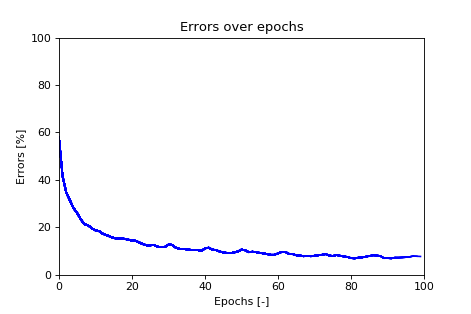

test error Net 7.70% 77/1000 	 Learning rate 56294995342131.2031		
Finish


In [230]:
## Define variables
N, normalize = 1000, True
hidden_layer = 200
epochs, mini_batch_size, dyn_lr, verbose = 100, 100, 0.2, 2
criterion = nn.MSELoss()

# Define models
model_up = Net_Conv(hidden_layer)

# Process data
train_input, train_classes, train_target, test_input, test_classes, test_target = import_data(N, normalize)

train_input_up, train_input_down, train_classes_up, train_classes_down,  \
    test_input_up, test_input_down, test_classes_up, test_classes_down = \
    split_data(train_input, train_classes, test_input, test_classes)

model_up, criterion, train_input_up, train_classes_up, train_target, test_input_up, test_classes_up, test_target = \
    define_device(model_up, criterion, train_input_up, train_classes_up, train_target, test_input_up, test_classes_up, test_target)

# Main process
loss = []
xdata = []
nb_error_test = []

fig,ax = plt.subplots(1,1)
ax.set_title('Errors over epochs')
ax.set_xlabel('Epochs [-]') ; ax.set_ylabel('Errors [%]')
ax.set_xlim(0, repeat) ; ax.set_ylim(0, 100)

for e in range(epochs):
    # Training model    
    loss.append(train_model(model_up, criterion, train_input_up, train_classes_up, mini_batch_size, lr = dyn_lr, verbose = verbose))
    error_e = compute_nb_errors(model_up, test_input_up, test_classes_up, mini_batch_size)
    
    # Plot results
    xdata.append(e)
    nb_error_test.append((100 * error_e) / test_input_up.size(0))
    plot_results(fig, ax, xdata, nb_error_test)
    
    print('test error Net {:0.2f}% {:d}/{:d} \t Learning rate {:0.4f}'.format((100 * error_e) / test_input_up.size(0),\
                                                  error_e, test_input_up.size(0), dyn_lr), end = "\t\t\r")
    
    # Dynamically adapt learning rate
    dyn_lr = adapt_learning_rate(dyn_lr, loss, e)
    
print("\nFinish")